## Figure S5A, Distribution of ribosome-protected fragments

## Mission 2

이번 미션에서는 start codon 주변에서 ribosome-protected fragment의 분포를 한 번 살펴보겠습니다. 보통은 RPF의 5'-end 분포가 start codon 앞 15nt 정도에서부터 본격적으로 많이 나오고, 거기서부터 CDS를 걸쳐서 3nt 주기로 올록볼록한 패턴이 나타납니다.

이 그림을 제대로 그리려면 genome coordinate를 start codon을 기준으로 변환해서 작업해야 하지만, 이번 미션에서는 난이도를 적절히 내리기 위해서 start codon이 포함된 exon에 존재하는 5' end만 추려서 작업하도록 합시다. (여유가 좀 있어서 난이도를 적당히 올리고 싶은 분들은 negative strand를 포함할 수도 있고, start codon과 다른 exon에 있는 경우를 포함할 수도 있습니다. 또한 APPRIS 등을 기반으로 해서 transcript 중에 가장 )

In [7]:
%cd ../tst/binfo1-datapack1

/home/delee/class/생정1/tst/binfo1-datapack1


우선 annotation에서 start codon이 포함된 exon만 추립니다. Gene 한 개에 isoform이 여러 개 있는 경우 모두 쓰면 read가 너무 부풀려질 수 있기 때문에 우선 transcript support level이 1인 것만 추려서 사용합니다. 여전히 TSL 1만 쓰더라도 부풀려질 가능성은 있기 때문에 제대로 하자면 APPRIS나 RNA-seq 데이터 기준으로 하나만 선정하는 것이 좋습니다만, 일단 여기서는 간단히..

그리고, - strand가 들어가면 좀 계산이 복잡해지니까 또 간단하게 하기 위해서 + strand만 고릅니다. 이번엔 일단 무조건 간단하게 해 봅시다~

In [9]:
!grep ' start_codon .*+.*transcript_support_level "1"' gencode.gtf | \
 sed -e 's/ [^ ]*transcript_id "\([^"]*\)".*$/ \1/g' > gencode-start.gtf
!head gencode-start.gtf

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script
grep: gencode.gtf: No such file or directory


start codon가 들어가 있는 exon들을 고르기 위해서 미리 + strand에 있는 exon를 추립니다.. start codon 쪽에서 TSL 기준으로 골랐기 때문에 여기서는 고르지 않아도 됩니다. 물론 좀 느려지기는 하지만...

In [ ]:
!grep '	exon	.*	+	' gencode.gtf | \
 sed -e 's/	[^	]*transcript_id "\([^"]*\)".*$/	\1/g' > gencode-plusexon.gtf
!head gencode-plusexon.gtf

그 다음엔 exon 리스트와 start codon 리스트를 겹치고, transcript가 같은 것만 살려둡니다. 기왕 좀 다루기 쉽도록 출력은 bed로 하면서 좌표계를 바꿉니다. 결과는 bedtools에서 빠르게 다룰 수 있게 sort해 둡니다.

In [ ]:
!bedtools intersect -a gencode-start.gtf -b gencode-plusexon.gtf -wa -wb | \
 awk -F'	' -v OFS='	' '$9 == $18 { print $10, $13-1, $14, $18, $4-1, $16; }' | \
 sort -k1,1 -k2,3n -k4,4 > gencode-exons-containing-startcodon.bed
!head gencode-exons-containing-startcodon.bed; tail gencode-exons-containing-startcodon.bed

컬럼 4번에 transcript id, 5번에 start codon 위치를 넣었는데, start codon이 같은 것들이 여러개 눈에 띕니다. 아주 찝찝하지만, 우선 이번은 간단하게 할 것이기 때문에 눈을 질끈 감고 넘어가 봅시다.

이제 alignment를 준비합니다. + strand alignment에서 read length가 짧은 것도 미리 필터링 합니다. RPF는 보통 25nt 이상이기 때문에 그 이하는 거의 확실히 rRNA, tRNA 등에서 오염된 것들입니다. SAM 파일 전체를 필터링해서 다시 인코딩하기 때문에 시간이 좀 걸립니다.

In [ ]:
!(samtools view -H RPF-siLuc.bam; \
  samtools view -F20 RPF-siLuc.bam | \
  bioawk -c sam '{ if (length($seq) >= 25) print $0; }') | \
 samtools view -b -o filtered-RPF-siLuc.bam

큰 일을 했으니 용량을 한 번 봅니다.

In [ ]:
!ls -al *RPF-siLuc.bam

자 이제 read의 5' end 위치를 셉니다. bedtools의 `genomecov`를 쓰면 아주 편리합니다.

In [ ]:
!bedtools genomecov -ibam filtered-RPF-siLuc.bam -bg -5 > fivepcounts-RPF-siLuc.bed
!head fivepcounts-RPF-siLuc.bed

그렇게 match 된 것들 중에 앞에서 찾은 start codon을 포함한 exon과 겹치는 것만 골라냅니다.

In [ ]:
!bedtools intersect -a fivepcounts-RPF-siLuc.bed -b gencode-exons-containing-startcodon.bed \
 -wa -wb -nonamecheck > fivepcounts-filtered-RPF-siLuc.txt
!head fivepcounts-filtered-RPF-siLuc.txt

모든 준비가 끝났습니다. 이제 Figure S5A 도전해 보세요!

* stop codon은 빼고 start codon 만입니다.
* 논문에서는 처리가 어려운 부분까지 모두 포함됐고, read를 중첩해서 세지 않았기 때문에, 여기서 세는 것과는 수치는 다를 수 있습니다.
* `pandas`로 한꺼번에 데이터를 모두 불러들이면 메모리가 부족할 수도 있습니다. 그런 경우에는 chunk를 쓰거나, 줄 단위로 처리해 보세요.

In [1]:
import pandas as pd

In [ ]:
#sinLuc

In [ ]:
# read table with df
f = open("./binfo1-datapack1/fivepcounts-filtered-RPF-siLuc.txt", "r")
ff = f.read().split('\n')

for i in list(range(len(ff))):
    ff[i] = ff[i].split('\t')

ff = pd.DataFrame(ff)

In [ ]:
ff.iloc[:,8] = pd.to_numeric(ff.iloc[:,8])
ff.iloc[:,5] = pd.to_numeric(ff.iloc[:,5])
ff.iloc[:,3] = pd.to_numeric(ff.iloc[:,3])
ff.iloc[:,1] = pd.to_numeric(ff.iloc[:,1])
ff.iloc[:,2] = pd.to_numeric(ff.iloc[:,2])

In [43]:
ff["rel_pos"] = ff.iloc[:,1]-ff.iloc[:,8]
ff.head()

,0,1,2,3,4,5,6,7,8,9,rel_pos
0,chr1,4878048.0,4878049.0,1.0,chr1,4878010.0,4878205,ENSMUST00000134384.8,4878136.0,+,-88.0
1,chr1,4878048.0,4878049.0,1.0,chr1,4878045.0,4878205,ENSMUST00000027036.11,4878136.0,+,-88.0
2,chr1,4878077.0,4878078.0,1.0,chr1,4878010.0,4878205,ENSMUST00000134384.8,4878136.0,+,-59.0
3,chr1,4878077.0,4878078.0,1.0,chr1,4878045.0,4878205,ENSMUST00000027036.11,4878136.0,+,-59.0
4,chr1,4878077.0,4878078.0,1.0,chr1,4878052.0,4878205,ENSMUST00000150971.8,4878136.0,+,-59.0


In [44]:
cnt_li = []

for i in set(ff["rel_pos"]):
    cnt_li.append(sum(ff.loc[ff.loc[:,"rel_pos"] == i,3])/1000)

In [45]:
m_f = pd.DataFrame(set(ff["rel_pos"]), columns=["rel_pos"])
m_f["rel_cnt"] = cnt_li
m_f.head()

,rel_pos,rel_cnt
0,0.0,26.289
1,1.0,5.234
2,2.0,14.082
3,3.0,14.167
4,4.0,3.051


In [12]:
import matplotlib.pyplot as plt
import seaborn as sb

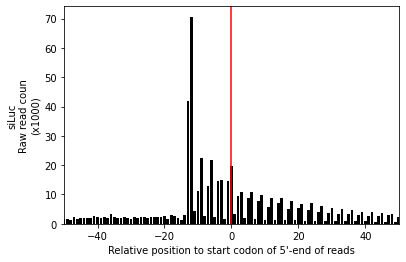

In [52]:
plt.bar(m_f.loc[:,"rel_pos"],m_f.loc[:,"rel_cnt"], color="k")
plt.xlabel('Relative position to start codon of 5\'-end of reads')
plt.ylabel('siLuc\nRaw read coun\n(x1000)')
plt.axvline(0,c="r") #, lw=0.5)
plt.xlim([-50,50])
plt.savefig("siLuc.png",dpi=300)
plt.show()

In [ ]:
#siLin28a

In [47]:
f = open("./binfo1-datapack1/fivepcounts-filtered-RPF-siLin28a.txt", "r")
ff = f.read().split('\n')

for i in list(range(len(ff))):
    ff[i] = ff[i].split('\t')

ff = pd.DataFrame(ff)
ff
# 1~2 5'end 구간,
# 3 : 해당 구간에 있는 gene 개수
#` 5~6 : exon의 start, end location
# 8 : start codon start 위치 
ff.iloc[:,8] = pd.to_numeric(ff.iloc[:,8])
ff.iloc[:,5] = pd.to_numeric(ff.iloc[:,5])
ff.iloc[:,3] = pd.to_numeric(ff.iloc[:,3])
ff.iloc[:,1] = pd.to_numeric(ff.iloc[:,1])
ff.iloc[:,2] = pd.to_numeric(ff.iloc[:,2])

ff["rel_pos"] = ff.iloc[:,1]-ff.iloc[:,8]
ff.head()

,0,1,2,3,4,5,6,7,8,9,rel_pos
0,chr1,4878043.0,4878044.0,1.0,chr1,4878010.0,4878205,ENSMUST00000134384.8,4878136.0,+,-93.0
1,chr1,4878056.0,4878057.0,3.0,chr1,4878010.0,4878205,ENSMUST00000134384.8,4878136.0,+,-80.0
2,chr1,4878056.0,4878057.0,3.0,chr1,4878045.0,4878205,ENSMUST00000027036.11,4878136.0,+,-80.0
3,chr1,4878056.0,4878057.0,3.0,chr1,4878052.0,4878205,ENSMUST00000150971.8,4878136.0,+,-80.0
4,chr1,4878074.0,4878075.0,1.0,chr1,4878010.0,4878205,ENSMUST00000134384.8,4878136.0,+,-62.0


In [49]:
cnt_li = []

for i in set(ff["rel_pos"]):
    cnt_li.append(sum(ff.loc[ff.loc[:,"rel_pos"] == i,3])/1000)
m_f = pd.DataFrame(set(ff["rel_pos"]), columns=["rel_pos"])
m_f["rel_cnt"] = cnt_li
m_f.head()

,rel_pos,rel_cnt
0,0.0,19.658
1,1.0,3.188
2,2.0,9.469
3,3.0,10.956
4,4.0,2.011


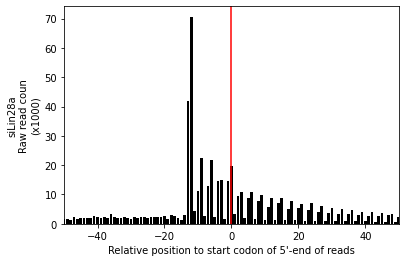

In [56]:
plt.bar(m_f.loc[:,"rel_pos"],m_f.loc[:,"rel_cnt"], color="k")
plt.xlabel('Relative position to start codon of 5\'-end of reads')
plt.ylabel('siLin28a\nRaw read coun\n(x1000)')
plt.axvline(0,c="r") #, lw=0.5)
# plt.savefig("siLin28a.png",dpi=300)
plt.xlim([-50,50])
plt.show()